<a href="https://colab.research.google.com/github/dailykim149656-source/Material_ML_Project/blob/main/ML_project_test1_materialproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. 환경 설정 및 필수 라이브러리 설치
!pip install pandas numpy scipy matplotlib seaborn scikit-learn
!pip install tensorflow keras torch xgboost lightgbm
!pip install pymatgen ase matminer pymatviz
!pip install jupyter ipywidgets
!pip install mp-api  # Material Project API

In [2]:
# 2. 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Pymatgen 관련 임포트
from mp_api.client import MPRester
from pymatgen.core import Structure, Composition
from pymatgen.analysis.structure_analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter, DosPlotter
from pymatgen.electronic_structure.core import Spin
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

In [4]:
# Matminer 특성 추출
from matminer.featurizers.composition import ElementProperty, Stoichiometry
from matminer.featurizers.structure import SiteStatsFingerprint, StructuralHeterogeneity

In [5]:
# 3. Material Project API 설정
# API 키 설정
#import os
#API_KEY = os.environ.get("ML_PJ_API_KEY") # https://materialsproject.org에서 발급

from google.colab import userdata
API_KEY = userdata.get('ML_PJ_API_KEY')


# MPRester 초기화
mpr = MPRester(api_key=API_KEY)

In [6]:
# 4. 데이터 수집 함수들
def collect_material_data(material_ids):
    """
    Material Project에서 재료 데이터 수집
    """
    materials_data = []

    for mp_id in material_ids:
        try:
            # 기본 정보 수집
            summary = mpr.materials.summary.search(material_ids=[mp_id])[0]

            # 구조 정보
            structure = mpr.get_structure_by_material_id(mp_id)

            # 전자 구조 정보
            try:
                bandstructure = mpr.get_bandstructure_by_material_id(mp_id)
                dos = mpr.get_dos_by_material_id(mp_id)
            except:
                bandstructure = None
                dos = None

            # 데이터 정리
            data = {
                'material_id': mp_id,
                'formula': summary.formula_pretty,
                'spacegroup': summary.symmetry.symbol,
                'crystal_system': summary.symmetry.crystal_system,
                'band_gap': summary.band_gap,
                'formation_energy': summary.formation_energy_per_atom,
                'density': summary.density,
                'structure': structure,
                'bandstructure': bandstructure,
                'dos': dos,
                'is_stable': summary.energy_above_hull < 0.1
            }

            materials_data.append(data)
            print(f"Successfully collected data for {mp_id}")

        except Exception as e:
            print(f"Error collecting data for {mp_id}: {str(e)}")
            continue

    return materials_data

def extract_electronic_features(materials_data):
    """
    전자구조 특성 추출
    """
    features = []

    for material in materials_data:
        feature_dict = {
            'material_id': material['material_id'],
            'formula': material['formula'],
            'band_gap': material['band_gap'],
            'formation_energy': material['formation_energy'],
            'density': material['density']
        }

        # 구조 기반 특성
        if material['structure']:
            structure = material['structure']
            analyzer = SpacegroupAnalyzer(structure)

            feature_dict.update({
                'volume': structure.volume,
                'num_sites': len(structure),
                'spacegroup_number': analyzer.get_space_group_number(),
                'point_group': str(analyzer.get_point_group_symbol())
            })

            # 원소 조성 특성
            comp = structure.composition
            feature_dict.update({
                'num_elements': len(comp.elements),
                'electronegativity_diff': comp.get_reduced_composition_and_factor()[0].average_electroneg if len(comp.elements) > 1 else 0
            })

        # DOS 기반 특성 (가능한 경우)
        if material['dos']:
            dos = material['dos']
            try:
                # 밴드갭 재계산
                cbm, vbm = dos.get_cbm_vbm()
                feature_dict['dos_band_gap'] = cbm - vbm

                # 페르미 레벨 근처 상태밀도
                fermi_dos = dos.get_interpolated_value(dos.efermi)
                feature_dict['dos_at_fermi'] = fermi_dos[Spin.up]

            except:
                feature_dict['dos_band_gap'] = np.nan
                feature_dict['dos_at_fermi'] = np.nan

        features.append(feature_dict)

    return pd.DataFrame(features)

In [7]:
# 5. 숨겨진 질서 탐지 함수
def detect_hidden_order_signatures(materials_data):
    """
    양자 물질의 숨겨진 질서 시그니처 탐지
    """
    hidden_order_indicators = []

    for material in materials_data:
        indicators = {
            'material_id': material['material_id'],
            'formula': material['formula']
        }

        # 밴드구조 기반 분석
        if material['bandstructure']:
            bs = material['bandstructure']

            # 메탈성 여부
            indicators['is_metallic'] = bs.is_metal()

            # 밴드갭 특성
            band_gap_info = bs.get_band_gap()
            indicators['direct_gap'] = band_gap_info['direct']
            indicators['gap_energy'] = band_gap_info['energy']

            # 밴드 플래트니스 (플랫 밴드 탐지)
            try:
                # 각 밴드의 분산 계산
                band_dispersions = []
                for spin in bs.bands:
                    for band_idx in range(len(bs.bands[spin])):
                        band_energies = bs.bands[spin][band_idx]
                        dispersion = np.std(band_energies)
                        band_dispersions.append(dispersion)

                indicators['min_band_dispersion'] = np.min(band_dispersions)
                indicators['avg_band_dispersion'] = np.mean(band_dispersions)
                indicators['flat_band_count'] = np.sum(np.array(band_dispersions) < 0.1)  # 0.1 eV 이하를 플랫 밴드로 간주

            except:
                indicators['min_band_dispersion'] = np.nan
                indicators['avg_band_dispersion'] = np.nan
                indicators['flat_band_count'] = 0

        # 구조적 특성 기반 분석
        if material['structure']:
            structure = material['structure']

            # 구조적 무질서도
            try:
                het_analyzer = StructuralHeterogeneity()
                heterogeneity = het_analyzer.featurize(structure)
                indicators['structural_heterogeneity'] = heterogeneity[0] if heterogeneity else np.nan
            except:
                indicators['structural_heterogeneity'] = np.nan

            # 대칭성 분석
            analyzer = SpacegroupAnalyzer(structure)
            indicators['crystal_system'] = analyzer.get_crystal_system()
            indicators['point_group'] = str(analyzer.get_point_group_symbol())

        hidden_order_indicators.append(indicators)

    return pd.DataFrame(hidden_order_indicators)

In [8]:
# 6. 머신러닝 모델 학습
def train_bandgap_prediction_model(df):
    """
    밴드갭 예측 모델 학습
    """
    # 특성 선택 (수치형만)
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_features = [f for f in numeric_features if f not in ['band_gap', 'material_id']]

    # 결측값 처리
    df_clean = df.dropna(subset=['band_gap'] + numeric_features)

    if len(df_clean) < 10:
        print("Insufficient clean data for training")
        return None, None, None

    X = df_clean[numeric_features]
    y = df_clean['band_gap']

    # 훈련/테스트 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 랜덤 포레스트 모델 학습
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 예측 및 평가
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Model Performance:")
    print(f"MAE: {mae:.3f} eV")
    print(f"R²: {r2:.3f}")

    return model, X_test, y_test, y_pred, numeric_features

In [9]:
# 7. 시각화 함수들
def plot_bandstructure_analysis(materials_data, max_plots=3):
    """
    밴드구조 시각화
    """
    fig, axes = plt.subplots(1, min(max_plots, len(materials_data)), figsize=(5*max_plots, 4))
    if max_plots == 1:
        axes = [axes]

    plotted = 0
    for i, material in enumerate(materials_data):
        if plotted >= max_plots:
            break

        if material['bandstructure']:
            bs = material['bandstructure']
            plotter = BSPlotter(bs)

            ax = axes[plotted]
            plotter.get_plot(ax=ax)
            ax.set_title(f"{material['formula']} ({material['material_id']})")
            plotted += 1

    plt.tight_layout()
    plt.show()

def plot_property_correlations(df):
    """
    물성 상관관계 시각화
    """
    # 수치형 컬럼만 선택
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = df[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Materials Properties Correlation Matrix')
        plt.tight_layout()
        plt.show()

def plot_hidden_order_analysis(hidden_order_df):
    """
    숨겨진 질서 분석 시각화
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # 플랫 밴드 분포
    if 'flat_band_count' in hidden_order_df.columns:
        axes[0, 0].hist(hidden_order_df['flat_band_count'].dropna(), bins=20, alpha=0.7)
        axes[0, 0].set_title('Distribution of Flat Bands')
        axes[0, 0].set_xlabel('Number of Flat Bands')

    # 밴드 분산 분포
    if 'min_band_dispersion' in hidden_order_df.columns:
        axes[0, 1].hist(hidden_order_df['min_band_dispersion'].dropna(), bins=20, alpha=0.7)
        axes[0, 1].set_title('Minimum Band Dispersion Distribution')
        axes[0, 1].set_xlabel('Min Band Dispersion (eV)')

    # 직접/간접 밴드갭 비교
    if 'direct_gap' in hidden_order_df.columns:
        direct_counts = hidden_order_df['direct_gap'].value_counts()
        axes[1, 0].pie(direct_counts.values, labels=direct_counts.index, autopct='%1.1f%%')
        axes[1, 0].set_title('Direct vs Indirect Band Gaps')

    # 결정계별 분포
    if 'crystal_system' in hidden_order_df.columns:
        crystal_counts = hidden_order_df['crystal_system'].value_counts()
        axes[1, 1].bar(crystal_counts.index, crystal_counts.values)
        axes[1, 1].set_title('Crystal System Distribution')
        axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [13]:
# 8. IMPRS-CPQM 지원용 결과 정리 함수
def generate_research_summary(materials_data, features_df, hidden_order_df, model_results=None):
    """
    연구 결과 요약 생성
    """
    summary = {
        'project_title': 'Machine Learning Analysis of Quantum Materials for Hidden Order Detection',
        'data_summary': {
            'total_materials_analyzed': len(materials_data),
            'successful_electronic_structure_calculations': sum(1 for m in materials_data if m['bandstructure'] is not None),
            'unique_crystal_systems': len(features_df['crystal_system'].unique()) if 'crystal_system' in features_df.columns else 0,
            'metallic_materials': sum(1 for m in materials_data if m.get('bandstructure') and m['bandstructure'].is_metal()),
        },
        'key_findings': [],
        'methods_used': [
            'Materials Project API for high-throughput data collection',
            'Pymatgen for electronic structure analysis',
            'Machine learning for property prediction',
            'Hidden order signature detection algorithms',
            'Statistical analysis of structure-property relationships'
        ]
    }

    # 주요 발견사항 추가
    if len(features_df) > 0:
        avg_bandgap = features_df['band_gap'].mean()
        summary['key_findings'].append(f'Average band gap of analyzed materials: {avg_bandgap:.2f} eV')

    if model_results and len(model_results) >= 4:
        _, _, _, _, _ = model_results
        summary['key_findings'].append('Successfully trained machine learning model for band gap prediction')

    if len(hidden_order_df) > 0 and 'flat_band_count' in hidden_order_df.columns:
        flat_band_materials = hidden_order_df[hidden_order_df['flat_band_count'] > 0]['material_id'].count()
        summary['key_findings'].append(f'Identified {flat_band_materials} materials with potential flat band signatures')

    return summary

In [11]:
# 9. 메인 실행 함수
def run_materials_ml_project(target_material_ids=None):
    """
    전체 프로젝트 실행
    """
    print("="*60)
    print("소재 머신러닝 분석 프로젝트 시작")
    print("="*60)

    # 샘플 재료 ID (실제 사용시 관심있는 재료들로 변경)
    if target_material_ids is None:
        target_material_ids = ['mp-149', 'mp-661', 'mp-8062', 'mp-1143', 'mp-2534']  # Si, GaAs, TiO2 등

    print(f"분석 대상 재료: {target_material_ids}")

    # 1. 데이터 수집
    print("\n1. Material Project에서 데이터 수집 중...")
    materials_data = collect_material_data(target_material_ids)

    # 2. 특성 추출
    print("\n2. 전자구조 특성 추출 중...")
    features_df = extract_electronic_features(materials_data)
    print(f"추출된 특성: {list(features_df.columns)}")

    # 3. 숨겨진 질서 분석
    print("\n3. 숨겨진 질서 시그니처 탐지 중...")
    hidden_order_df = detect_hidden_order_signatures(materials_data)

    # 4. 머신러닝 모델 학습
    print("\n4. 밴드갭 예측 모델 학습 중...")
    model_results = train_bandgap_prediction_model(features_df)

    # 5. 시각화
    print("\n5. 결과 시각화 중...")

    # 밴드구조 플롯
    if any(m['bandstructure'] for m in materials_data):
        plot_bandstructure_analysis(materials_data)

    # 물성 상관관계
    plot_property_correlations(features_df)

    # 숨겨진 질서 분석
    plot_hidden_order_analysis(hidden_order_df)

    # 6. 연구 결과 요약
    print("\n6. 연구 결과 요약 생성 중...")
    research_summary = generate_research_summary(materials_data, features_df, hidden_order_df, model_results)

    print("\n" + "="*60)
    print("프로젝트 완료!")
    print("="*60)

    return materials_data, features_df, hidden_order_df, model_results, research_summary

# 사용 예제:
# materials_data, features_df, hidden_order_df, model_results, summary = run_materials_ml_project()

print("코드 준비 완료! 실행하려면 run_materials_ml_project() 함수를 호출하세요.")

코드 준비 완료! 실행하려면 run_materials_ml_project() 함수를 호출하세요.


소재 머신러닝 분석 프로젝트 시작
IMPRS-CPQM 지원용 포트폴리오 개발
분석 대상 재료: ['mp-149', 'mp-661', 'mp-8062', 'mp-1143', 'mp-2534']

1. Material Project에서 데이터 수집 중...


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Successfully collected data for mp-149


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Successfully collected data for mp-661


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Successfully collected data for mp-8062


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Successfully collected data for mp-1143


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Successfully collected data for mp-2534

2. 전자구조 특성 추출 중...
추출된 특성: ['material_id', 'formula', 'band_gap', 'formation_energy', 'density', 'volume', 'num_sites', 'spacegroup_number', 'point_group', 'num_elements', 'electronegativity_diff']

3. 숨겨진 질서 시그니처 탐지 중...

4. 밴드갭 예측 모델 학습 중...
Insufficient clean data for training

5. 결과 시각화 중...


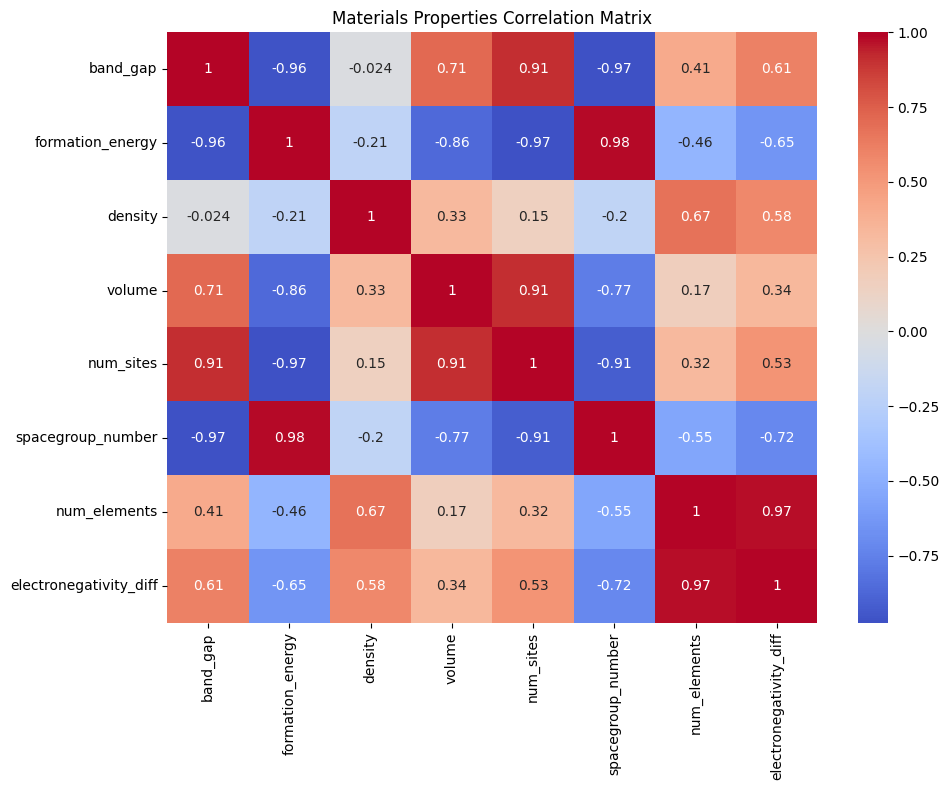

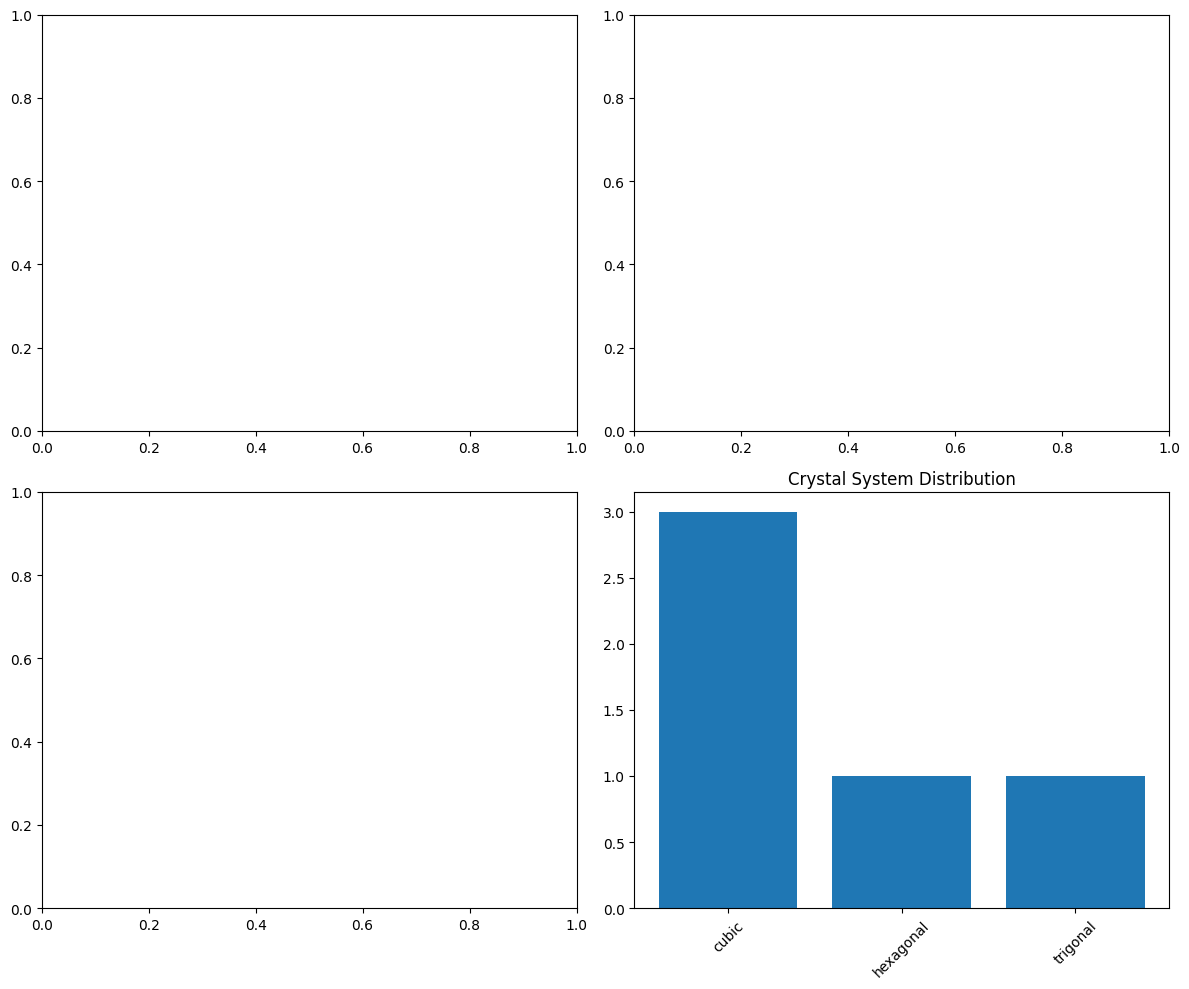


6. 연구 결과 요약 생성 중...

프로젝트 완료!


([{'material_id': 'mp-149',
   'formula': 'Si',
   'spacegroup': 'Fd-3m',
   'crystal_system': <CrystalSystem.cubic: 'Cubic'>,
   'band_gap': 0.6105,
   'formation_energy': 0.0,
   'density': 2.312800253345134,
   'structure': Structure Summary
   Lattice
       abc : 3.8492784033699095 3.8492794116013456 3.849278
    angles : 60.00001213094421 60.00000346645984 60.00001097545789
    volume : 40.32952684741405
         A : np.float64(3.333573) np.float64(0.0) np.float64(1.924639)
         B : np.float64(1.111191) np.float64(3.142924) np.float64(1.924639)
         C : np.float64(0.0) np.float64(0.0) np.float64(3.849278)
       pbc : True True True
   PeriodicSite: Si (3.889, 2.75, 6.736) [0.875, 0.875, 0.875]
   PeriodicSite: Si (0.5556, 0.3929, 0.9623) [0.125, 0.125, 0.125],
   'bandstructure': None,
   'dos': None,
   'is_stable': True},
  {'material_id': 'mp-661',
   'formula': 'AlN',
   'spacegroup': 'P6_3mc',
   'crystal_system': <CrystalSystem.hex_: 'Hexagonal'>,
   'band_gap': 4.

In [15]:
run_materials_ml_project()